# Cellpose/StarDist Segmentation

In this notebook, we will segment HeLa cell cytoplasms and nuclei with Cellpose and StarDist respectively. Finally we will  convert the resulting index images into ImgLib2 and legacy ImageJ regions of interest (ROI). This notebook requires Cellpose and StarDist in your conda/mamba environment. You can use the following `environment.yml` file below to create an environment with Cellpose, StarDist and PyImageJ.

```yaml
name: cellstar
channels:
    - conda-forge
    - defaults
dependencies:
    - pyimagej
    - jupyterlab
    - openjdk=11
    - pip
    - pip:
        - tensorflow==2.12.*
        - stardist
        - cellpose
```

⚠️**Warning**: The index image to legacy ImageJ ROI features are not yet included in the current released version of PyImageJ (version `1.4.1`). Until these features are included in the next release of PyImageJ, you can use them by installing the developer version of PyImageJ by cloning the PyImageJ GitHub [repository](https://github.com/imagej/pyimagej) and installing PyImageJ with `pip install -e .` in the cloned repository. Be sure to install PyImageJ in the correct conda/mamba environment.

In [1]:
import imagej
import imagej.convert as convert
import numpy as np
import matplotlib.pyplot as plt
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from cellpose import models

# initialize ImageJ
ij = imagej.init(mode='interactive')
print(f"ImageJ2 version: {ij.getVersion()}")

2023-09-29 14:20:38.844901: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-29 14:20:38.875596: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 14:20:39.019092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 14:20:39.019882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 14:20:39.761729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

ImageJ2 version: 2.14.0/1.54f


Before we get started with Cellpose and StarDist, let's also add some useful methods. Below is a simple way to filter an index image's labels based on a range of minimum and maximum values that define the number of pixels that make up a given label. Its important to note that this is not the same as **area** of the label/object, but instead simply the number of pixels that the label/object contains.

In [2]:
def filter_index_image(narr: np.ndarray, min_size:int, max_size:int):
    """
    Filter an index image's labels with a pixel size range.
    """
    unique = np.unique(narr)
    for label in unique:
        if label == 0:
            # skip the background
            continue
        
        # create a crop for each label
        bbox = get_bounding_box(np.where(narr == label))
        bbox_crop = narr[bbox[0]:bbox[2] + 1, bbox[1]:bbox[3] + 1].copy()
        bbox_crop[bbox_crop != label] = 0

        # get the number of pixels in label
        bbox_crop = bbox_crop.astype(bool)
        label_size = np.sum(bbox_crop)

        if not min_size <= label_size <= max_size:
            narr[narr == label] = 0
    
    return narr

def get_bounding_box(indices: np.ndarray):
    """
    Get the bounding box coordinates from a the label indices.
    """
    # get min and max bounds of indices array
    min_row = np.min(indices[0])
    min_col = np.min(indices[1])
    max_row = np.max(indices[0])
    max_col = np.max(indices[1])

    return (min_row, min_col, max_row, max_col)

Next let's open a 3D dataset `(X, Y, Channel)` of HeLa cells expressing a YFP tagged APOBEC3G (A3G) protein with a nuclear stain. This dataset has two channels:
1. DAPI (nuclear stain)
2. YFP (cytoplasmic A3G)

Both channels can be displayed side by side with `matplotlib.pyplot` as shown below. Note that we first need to convert the image data from a Java object (`net.imagej.DefaultDataset`) to either a `numpy.ndarray` or, if dimensional information is available, `xarray.DataArray`. Here we will let PyImageJ decide what's best as both a `numpy.ndarray` and `xarray.DataArray` will work with `matplotlib.pyplot.`

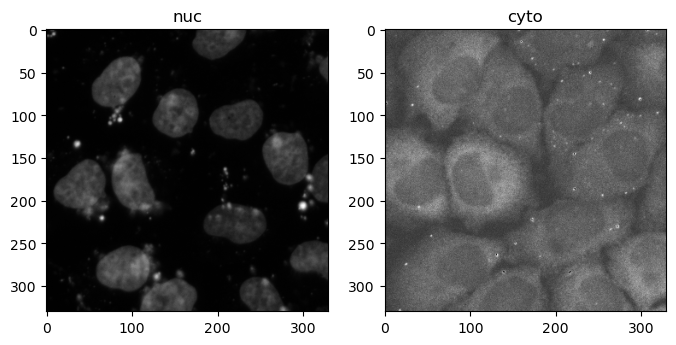

In [3]:
# open image data and convert to Python from Java
data = ij.io().open('https://media.imagej.net/pyimagej/3d/hela_a3g.tif')
xdata = ij.py.from_java(data)

# create a matplotlib subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# show each channel in each column of the matplotlib subplot
# xdata's image dimensions are: (row, col, ch)
axes[0].imshow(xdata[:, :, 0], cmap="gray")
axes[0].set_title('nuc')
axes[1].imshow(xdata[:, :, 1] * 125, cmap="gray")
axes[1].set_title('cyto')

# display the plot
plt.show()

**Note:** The cytoplasmic channel of this dataset is a little dark and the image is hard to see. Here we are multiplying the cytoplasmic channel input image by `125` to make it brighter. This only changes how the image is displayed and does not alter the original data.

With the data loaded we can now run StarDist on the nuclear channel and Cellpose on the cytoplasmic channel.

In [4]:
# run StarDist on nuclei channel
model = StarDist2D.from_pretrained('2D_versatile_fluo')
nuc_labels, _ = model.predict_instances(normalize(xdata[:, :, 0]))

# run Cellpose on cytoplasm (grayscale)
model = models.CellposeModel(gpu=False, model_type='cyto')
ch = [0, 0]
cyto_labels = model.eval(xdata[:, :, 1].data, channels=ch, diameter=72.1)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


StarDist and Cellpose both produce index images (_i.e._ images where labels/objects are defined by a single unique value, an index) but they return them in different objects. StarDist will return the index image as `numpy.ndarray` as well as a `dict` which contains additional information such as object probility values. Cellpose returns a `Tuple` with the `numpy.ndarray` index image as well as the vector flow data. Additional information about the outputs from StarDist can be found [here](https://stardist.net/docs/faq.html#how-do-i-evaluate-the-quality-of-the-predicted-results-of-a-model). For more information on Cellpose's output, see this [page](https://cellpose.readthedocs.io/en/latest/outputs.html).

Now that both StarDist and Cellpose have finished segmenting the nuclear and cytoplasmic channels respectively, lets look at the results:

In [ ]:
# display StarDist results
fig_n, axes_n = plt.subplots(1, 2, figsize=(8, 5))
axes_n[0].imshow(xdata[:, :, 0], cmap="gray")
axes_n[0].set_title('input')
axes_n[1].imshow(nuc_labels)
axes_n[1].set_title('StarDist output')
plt.show()

In [ ]:
# display cytoplasmic results
fig_c, axes_c = plt.subplots(1, 2, figsize=(8, 5))
axes_c[0].imshow(xdata[:, :, 1] * 125, cmap="gray")
axes_c[0].set_title('input')
axes_c[1].imshow(cyto_labels[0], cmap="cividis")
axes_c[1].set_title('Cellpose output')
plt.show()

Unfortunately, the input nuclear data for StarDist is noisy and has debris in the nuclear channel that we do not want. These objects have been segemented by StarDist and can been seen in the output index image. To clean up the StarDist result, we can use the functions we added earlier to this notebook to filter the small micronuclei and small debris from the index image.

In [ ]:
# filter small labels out from the nucleus index image
# by specifiying a pixel size range
ij.py.show(filter_index_image(nuc_labels, 500, 10000))

Finally let's display the two segmentations side-by-side:

In [ ]:
# display StarDist and Cellpose results
fig_c, axes_c = plt.subplots(1, 2, figsize=(8, 5))
axes_c[0].imshow(nuc_labels)
axes_c[0].set_title('StarDist output')
axes_c[1].imshow(cyto_labels[0], cmap="cividis")
axes_c[1].set_title('Cellpose output')

After obtaining the index images from StarDist and Cellpose respectively, we now have the option to convert the Cellpose and StarDist label images into two ImageJ/Fiji usable forms:

- Convert index image labels to `DefaultROITree`
- Convert index image labels to ROIs in the `RoiManager`

Let's first convert the index images to `DefaultROITree`s that contain ImgLib2 ROIs. A `DefaultROITree` can be used in headless environments and can be attached to `net.imagej.Dataset`s. ImgLib2 ROIs can easily be converted to the legacy ImageJ ROIs using the `ConvertService`.

In [ ]:
# convert to ImgLib2 ROI in a ROITree
nuc_roi_tree = convert.index_img_to_roi_tree(ij, nuc_labels)
cyto_roi_tree = convert.index_img_to_roi_tree(ij, cyto_labels[0])

# print the contents of the ROITree (nuclear ROIs)
len(nuc_roi_tree.children())
for i in range(len(nuc_roi_tree.children())):
    print(nuc_roi_tree.children().get(i).data())

In [ ]:
# convert a single ImgLib2 roi to a legacy ImageJ ROI with the ConvertService.
import scyjava as sj

imglib_polygon_roi = nuc_roi_tree.children().get(0).data()
ij_polygon_roi = ij.convert().convert(imglib_polygon_roi, sj.jimport('ij.gui.PolygonRoi'))
print(type(ij_polygon_roi))

Unlike a `DefaultROITree`, converting Index image labels to ROIs in the `RoiManager` **requires** an interactive or GUI PyImageJ session. The `RoiManager` does not function in headless environments.

After the `RoiManager` has been populated with ROIs, display the source image (_e.g._ `ij.ui().show()`) and check the `Show All` check box in the `RoiManager` to transfer the ROIs onto the displayed image.

In [ ]:
# convert to ImageJ ROI in RoiManager
ij.ui().show(data)
convert.index_img_to_roi_manager(ij, nuc_labels)
convert.index_img_to_roi_manager(ij, cyto_labels[0])

![Cellpose StarDist result](https://media.imagej.net/pyimagej/doc/images/cellpose_stardist_result.png)